# Diffusion Model on Swiss Roll (DDPM) - PyTorch Code

<div>
<iframe src="https://slides.com/naresh-ub/cvip-lec-15-16-17/embed" width="100%" height="500" title="Intro to GenAI" scrolling="no" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe>
</div>

In this notebook, we demonstrate a basic Diffusion Model training loop on a 2D Swiss Roll dataset.

---

## Theoretical Foundations

In **Understanding Diffusion Models: A Unified Perspective** (arXiv:2208.11970v1), the forward (noising) and reverse (denoising) processes are introduced as follows:

### Forward Process

We define a forward noising process

$$
q(x_t \mid x_{t-1}) = \mathcal{N} \bigl(x_t; \sqrt{\alpha_t}\,x_{t-1}, (1 - \alpha_t)\,\mathbf{I} \bigr),
$$

which is **Equation (31) from the PDF**. Iterating this from $ t=1 $ to $ t=T $ yields

$$
q(x_t \mid x_0)
= \mathcal{N}\Bigl(x_t; \sqrt{\bar{\alpha}_t}\,x_0,\,(1 - \bar{\alpha}_t)\,\mathbf{I}\Bigr),
$$

where $ \bar{\alpha}_t = \prod_{s=1}^t \alpha_s $. (See **Equation (70)** in the PDF.)

Hence, at any time-step $ t $, we can write

$$
x_t = \sqrt{\bar{\alpha}_t}\, x_0 \;+\; \sqrt{1 - \bar{\alpha}_t}\,\epsilon,
\quad \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I}).
$$

### Reverse Process

The reverse process aims to learn

$$
p_{\theta}(x_{t-1} \mid x_t),
$$

which we typically also model as a Gaussian with a mean depending on the learned noise predictor. A common parameterization in DDPM is:

$$
\mu_{\theta}(x_t, t)
= \frac{1}{\sqrt{\alpha_t}}
\left(
\,x_t \;-\;
\frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}}\;\hat{\epsilon}_{\theta}(x_t, t)
\right).
$$

(Compare to **Equation (125)** in the PDF or the typical DDPM references.)

---

## Notebook Overview

1. **Imports & Swiss Roll Generation**  
   - Import libraries and define a function to generate 2D Swiss Roll data.

2. **Denoising MLP**  
   - A multi-layer perceptron that predicts the noise $ \hat{\epsilon}_{\theta}(x_t, t) $ at each time-step.

3. **DiffusionProcess Class**  
   - Implements the forward diffusion (adding noise) and the reverse diffusion (denoising) steps.  
   - Uses a beta schedule to define $\beta_t$ and $\alpha_t = 1 - \beta_t$.  
   - Contains methods `diffuse_sample` (forward) and `denoise_step` (reverse).

4. **Visualization**  
   - `visualize_results` to plot samples during forward diffusion and reverse sampling.

5. **Training Loop**  
   - The main training loop randomly picks a time $ t $, noising $ x_0 $ to $ x_t $, then predicting the noise and minimizing MSE.

6. **Main**  
   - Instantiates and trains the model, then visualizes the final results.

In [1]:
# ------------------------------------------------------------------------------------------
# 1) Imports & Swiss Roll Generation
# ------------------------------------------------------------------------------------------

import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
import os

def generate_swiss_roll_batch(batch_size, device):
    """
    Generate a batch of points from the Swiss Roll dataset and return a torch.Tensor on the desired device.

    Forward process (q(x_t | x_0)):
      x_t = sqrt(alpha_bar_t)*x_0 + sqrt(1 - alpha_bar_t)*noise
    """
    data, _ = make_swiss_roll(batch_size)
    # Re-arrange and scale the axes
    data = data[:, [2, 0]] / 10.0 * np.array([1, -1])
    return torch.tensor(data, dtype=torch.float32, device=device)

## 2) Denoising MLP

We build a simple MLP to predict $ \hat{\epsilon}_{\theta}(x_t, t) $, the noise present in $ x_t $.  
This corresponds to the model used in the DDPM objective, where:

$$
\hat{\epsilon}_{\theta}(x_t, t) \approx \epsilon.
$$

In [2]:
class DenoisingMLP(nn.Module):
    def __init__(self, num_timesteps=40, input_dim=2, hidden_dim=4096):
        super().__init__()
        self.num_timesteps = num_timesteps
        self.shared_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.time_specific_decoders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, input_dim)  # Predicts noise
            ) for _ in range(num_timesteps)
        ])

    def forward(self, x, timestep: int):
        """
        Predict the noise at a given timestep (1-based index).
        """
        encoded = self.shared_encoder(x)
        return self.time_specific_decoders[timestep - 1](encoded)

## 3) DiffusionProcess Class

Implements:

- **Forward diffusion**:

$$
x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon,
$$

- **Reverse diffusion**:

$$
p_{\theta}(x_{t-1} \mid x_t).
$$

We use a beta schedule (transformed via sigmoid) to define $\beta_t$. Then

$$
\alpha_t = 1 - \beta_t,\quad
\bar{\alpha}_t = \prod_{s=1}^t \alpha_s,
$$

and so on, matching standard DDPM references.

In [3]:
class DiffusionProcess(nn.Module):
    def __init__(self, denoiser: nn.Module, num_timesteps=40, device='cuda'):
        super().__init__()
        self.denoiser = denoiser
        self.num_timesteps = num_timesteps
        self.device = device

        # --------------------------------------------------------------------
        # Setup noise schedule beta, alpha, alpha_cumprod, etc.
        # --------------------------------------------------------------------
        beta = torch.linspace(-18, 10, num_timesteps, device=device)
        self.beta = torch.sigmoid(beta) * (3e-1 - 1e-5) + 1e-5
        self.alpha = 1. - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)
        self.alpha_cumprod_prev = torch.cat(
            [torch.ones(1, device=device), self.alpha_cumprod[:-1]]
        )

        # Posterior variance for the reverse step:
        self.posterior_variance = (
            self.beta * (1. - self.alpha_cumprod_prev) / (1. - self.alpha_cumprod)
        )

    def diffuse_sample(self, x0, timestep):
        """
        Forward diffusion: q(x_t | x_0).
        x_t = sqrt(alpha_cumprod_t)*x_0 + sqrt(1 - alpha_cumprod_t)*noise
        """
        alpha_cumprod_t = self.alpha_cumprod[timestep - 1]
        noise = torch.randn_like(x0)
        xt = x0 * torch.sqrt(alpha_cumprod_t) + noise * torch.sqrt(1. - alpha_cumprod_t)
        return xt, noise

    def denoise_step(self, xt, timestep):
        """
        One reverse diffusion step: p_{theta}(x_{t-1} | x_t).
        Using standard DDPM formula:
          mu_theta = 1/sqrt(alpha_t) * (x_t - beta_t / sqrt(1 - alpha_cumprod_t) * pred_noise)
        """
        if timestep == 0:
            return xt

        pred_noise = self.denoiser(xt, timestep)

        t = timestep - 1  # 0-based index
        alpha_t = self.alpha[t]
        alpha_cumprod_t = self.alpha_cumprod[t]
        beta_t = self.beta[t]

        sqrt_recip_alpha_t = 1.0 / torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1.0 - alpha_cumprod_t)

        model_mean = (
            sqrt_recip_alpha_t
            * (xt - beta_t / sqrt_one_minus_alpha_cumprod_t * pred_noise)
        )

        if t > 0:
            posterior_variance_t = self.posterior_variance[t]
            sigma_t = torch.sqrt(posterior_variance_t)
            noise = torch.randn_like(xt)
        else:
            sigma_t = 0.0
            noise = torch.zeros_like(xt)

        return model_mean + sigma_t * noise

    def generate_samples(self, num_samples):
        """
        Draw samples x_T ~ N(0, I), and run T reverse steps to get x_0.
        """
        xt = torch.randn((num_samples, 2), device=self.device)
        samples = [xt]

        for t in reversed(range(1, self.num_timesteps + 1)):
            x_prev = self.denoise_step(samples[-1], t)
            samples.append(x_prev)

        return samples

## 4) Visualization

We visualize:
- The original data $ x_0 $,
- A halfway noised version ($ t=20 $),
- A fully noised version ($ t=40 $),
- And the reverse diffusion (samples) at steps 40, 20, and 0.

This helps confirm the forward and backward processes visually.

In [11]:
def visualize_results(diffusion_model, step):
    """
    Visualize forward and reverse diffusion processes and save figure.
    """
    plt.figure(figsize=(10, 6))
    device = diffusion_model.device

    # Forward process:
    x0 = generate_swiss_roll_batch(5000, device)
    xt_half, _ = diffusion_model.diffuse_sample(x0, 20)
    xt_full, _ = diffusion_model.diffuse_sample(x0, 40)

    stages = [x0.cpu().numpy(), xt_half.cpu().numpy(), xt_full.cpu().numpy()]
    titles = ['Original (t=0)', 'Halfway (t=20)', 'Noisy (t=40)']

    for idx, (data, title) in enumerate(zip(stages, titles)):
        plt.subplot(2, 3, 1 + idx)
        plt.scatter(data[:, 0], data[:, 1], alpha=0.1, s=1)
        plt.xlim(-2, 2); plt.ylim(-2, 2)
        plt.gca().set_aspect('equal')
        plt.title(title, fontsize=12)
        if idx == 0:
            plt.ylabel('Forward Process', fontsize=12)

    # Reverse process:
    samples = diffusion_model.generate_samples(5000)
    steps = [40, 20, 0]

    for idx, step_idx in enumerate(steps):
        plt.subplot(2, 3, 4 + idx)
        sample = samples[step_idx].cpu().detach().numpy()
        plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1, s=1, c='r')
        plt.xlim(-2, 2); plt.ylim(-2, 2)
        plt.gca().set_aspect('equal')
        plt.title(f'Step {40 - step_idx}', fontsize=12)
        if idx == 0:
            plt.ylabel('Reverse Process', fontsize=12)

    plt.tight_layout()
    os.makedirs("results_new", exist_ok=True)
    plt.savefig(f"results_new/diffusion_process_{step}.png", dpi=300)
    print("Training step:", step)
    plt.show()
    plt.close()

## 5) Training Loop

We train by:
1. Sampling $ x_0 $ from the data.
2. Sampling a random time-step $ t $.
3. Computing $ x_t $ via forward diffusion.
4. Predicting the noise and computing the MSE with the true noise.
5. Optimizing via gradient descent.

The standard DDPM objective is to minimize:

$$
\mathbb{E}_{t,\, x_0,\, \epsilon}
\;\bigl\|\,
\epsilon \;-\; \hat{\epsilon}_\theta(x_t,\, t)
\;\bigr\|^2.
$$

In [12]:
def train_diffusion_model(model, optimizer, num_epochs=150000, batch_size=64000):
    """
    The standard DDPM training loop for 2D Swiss Roll.
    Sample timesteps uniformly, noise up x0, predict noise, and optimize an MSE.
    """
    losses = []
    progress_bar = tqdm(range(num_epochs), desc="Training Progress")

    for step in progress_bar:
        x0 = generate_swiss_roll_batch(batch_size, model.device)

        # Sample a random timestep in [1, num_timesteps]
        timestep = torch.randint(1, model.num_timesteps + 1, (1,)).item()

        # Forward diffusion
        xt, noise = model.diffuse_sample(x0, timestep)

        # Predict noise
        pred_noise = model.denoiser(xt, timestep)

        # MSE Loss
        loss = nn.functional.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

        # Save visuals and checkpoints periodically
        if (step + 1) % 5000 == 0:
            visualize_results(model, step + 1)
            # torch.save({
            #     'step': step + 1,
            #     'model_state_dict': model.denoiser.state_dict(),
            #     'optimizer_state_dict': optimizer.state_dict(),
            #     'loss': loss.item(),
            # }, f"results/checkpoint_{step+1}.pth")

## 6) Main Execution

We instantiate the diffusion model, train it, and visualize final results.

Using device: cuda


Training Progress:   3%|▎         | 4995/150000 [01:18<37:43, 64.06it/s, Loss=0.0187]

Training step: 5000


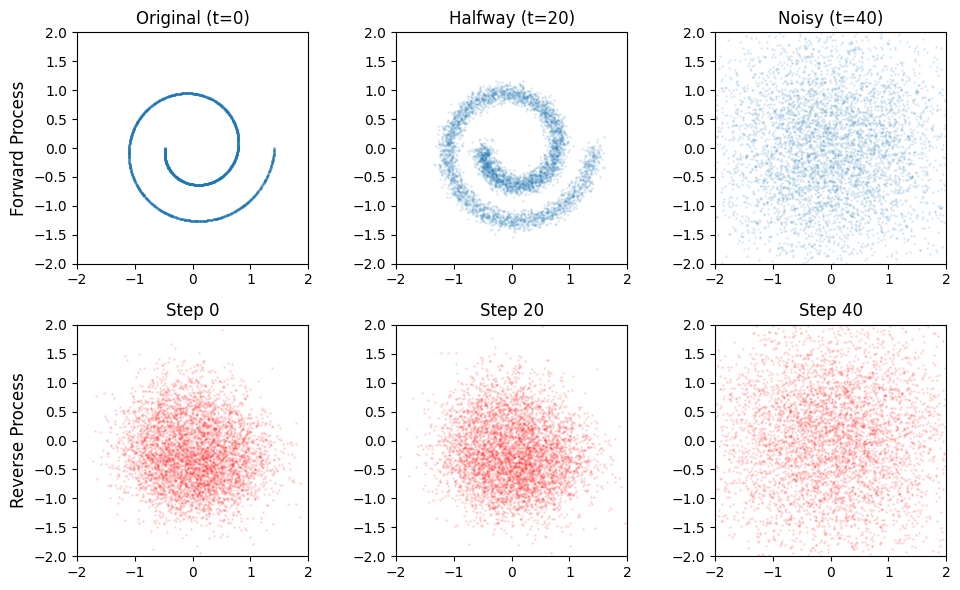

Training Progress:   7%|▋         | 9995/150000 [02:39<36:28, 63.98it/s, Loss=0.9972]  

Training step: 10000


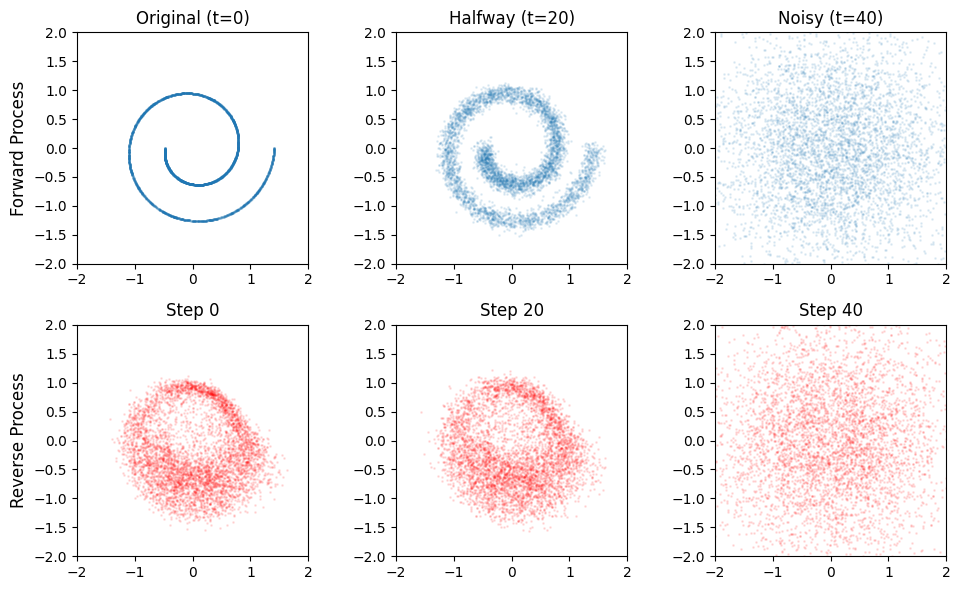

Training Progress:  10%|▉         | 14993/150000 [03:59<35:25, 63.51it/s, Loss=0.9734]  

Training step: 15000


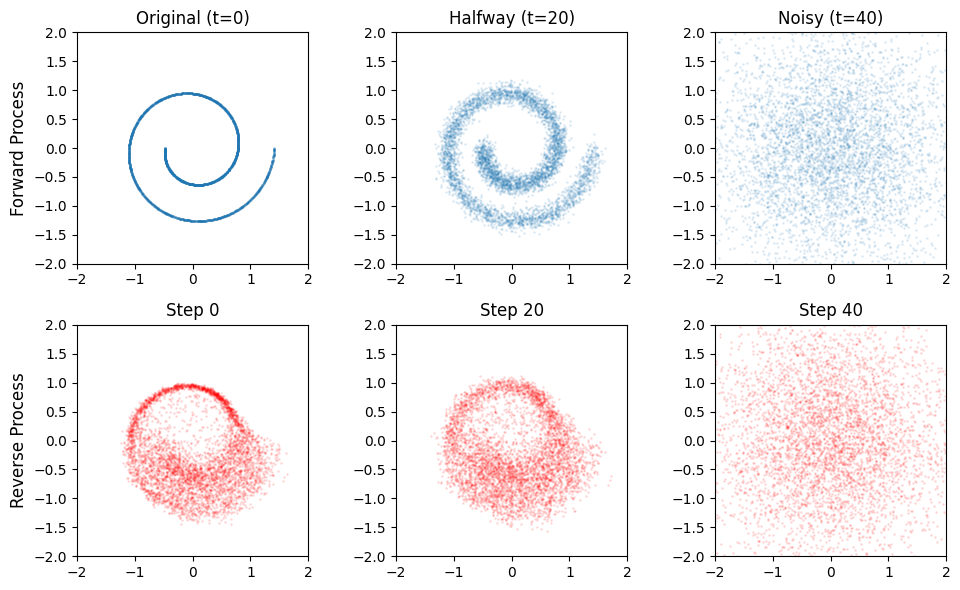

Training Progress:  13%|█▎        | 19994/150000 [05:20<33:43, 64.26it/s, Loss=0.0034]  

Training step: 20000


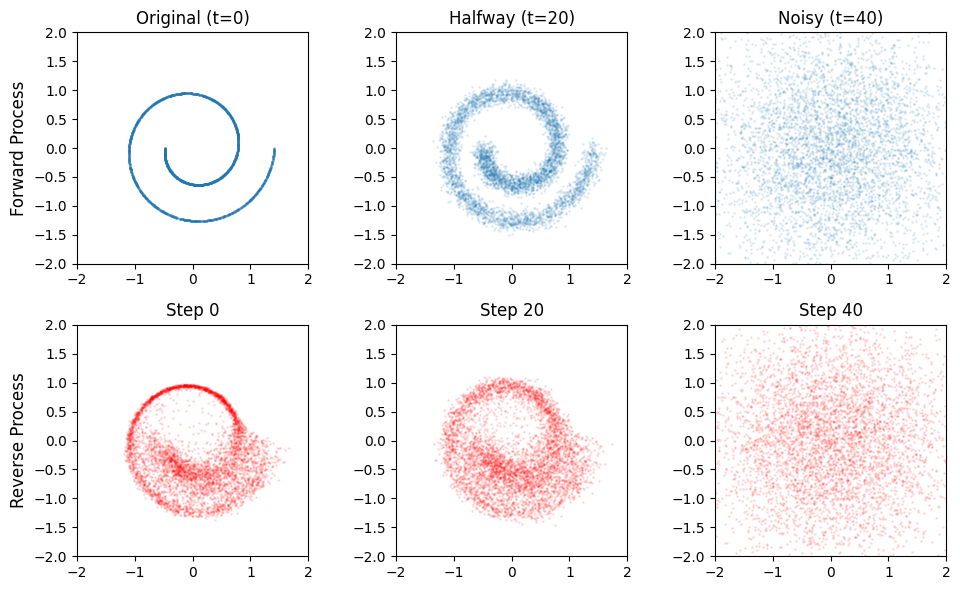

Training Progress:  17%|█▋        | 24996/150000 [06:41<34:27, 60.47it/s, Loss=0.2491]  

Training step: 25000


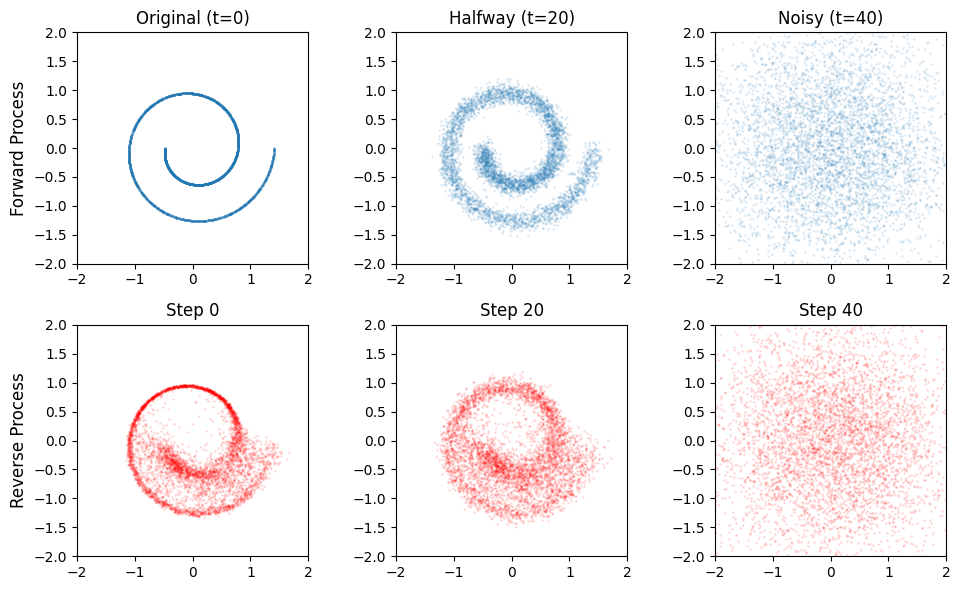

Training Progress:  20%|█▉        | 29995/150000 [08:01<31:47, 62.91it/s, Loss=0.0129]  

Training step: 30000


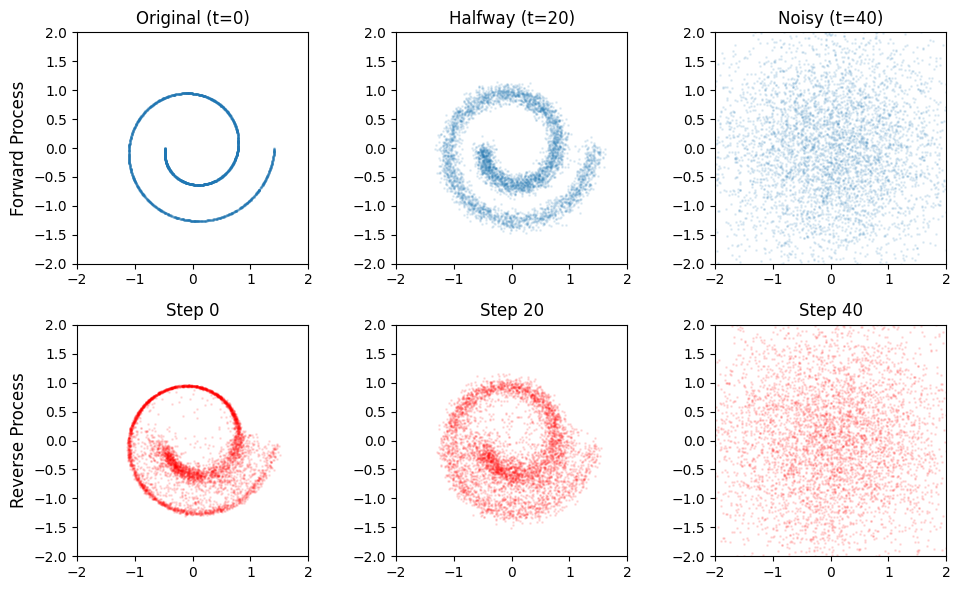

Training Progress:  20%|██        | 30501/150000 [08:11<32:05, 62.05it/s, Loss=0.2485]  


KeyboardInterrupt: 

In [13]:
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    denoiser = DenoisingMLP(hidden_dim=128).to(device)
    diffusion_model = DiffusionProcess(denoiser, device=device)
    optimizer = torch.optim.Adam(denoiser.parameters(), lr=1e-4)

    train_diffusion_model(diffusion_model, optimizer)
    visualize_results(diffusion_model, "final")

# End of Notebook

**Summary**:
- We used forward noising as in Equation (31)/(70) from the tu:
  $$
  q(x_t \mid x_0)
  = \mathcal{N}\bigl(x_t; \sqrt{\bar{\alpha}_t}\, x_0,\,(1 - \bar{\alpha}_t)\,\mathbf{I}\bigr).
  $$
- We used a standard DDPM reverse process:
  $$
  p_{\theta}(x_{t-1}\mid x_t),
  $$
  parameterized to predict the noise for the reverse step.
- Our training objective corresponds to the variational bound but simplifies to an MSE
  $$
  \|\epsilon - \hat{\epsilon}_{\theta}(x_t,\,t)\|^2.
  $$